In [35]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
import re
from Bio import SeqIO
from Bio.Seq import Seq

from matplotlib.collections import PolyCollection, PatchCollection
import matplotlib.patches as patches

In [36]:
plt.rcParams['svg.fonttype'] = 'none'

### compare the graphs

In [37]:
seq_order = {'_'.join(os.path.basename(l.split()[0]).replace('.fa', '').split('_')[::-1]) : idx for idx, l in enumerate(open('../graph_construction/mumemto/output/chr19.lengths', 'r').read().splitlines())}

In [38]:
mgc_regions = [(seq_order[l.split()[0]], int(l.split()[1]), int(l.split()[2])) for l in open('../graph_construction/mgc/output/chr19_mgc.missing.bed', 'r').read().splitlines()]
mum_regions = [(seq_order['chr19_' + l.split()[0]], int(l.split()[1]), int(l.split()[2])) for l in open('../graph_construction/mumemto/output/chr19_mgc.missing.bed', 'r').read().splitlines()]

In [6]:
def find_coll_blocks(mums, MAX_BREAK=10000):
    starts = np.array([m[1] for m in mums])
    mum_orders = starts.transpose().argsort()
    mum_gaps = []
    flips = set([])
    for i in range(mum_orders.shape[0]):
        cur = []
        for l in range(1, mum_orders.shape[1]):
            left, right = mum_orders[i][l-1], mum_orders[i][l]
            if mums[left][2][i] == mums[right][2][i]:
                if mums[left][2][i] == '+':
                    cur.append((left, right))
                else:
                    cur.append((right, left))
                    flips.add((right, left))
        mum_gaps.append(cur)
    common_gaps = set.intersection(*map(set, mum_gaps))
    left, right = zip(*common_gaps)
    left, right = set(list(left)), set(list(right))
    true_collinear_mums = sorted(list(left.intersection(right)))
    right_coll_mums = sorted(list(left.difference(set(true_collinear_mums)))) # have a right pair, but not a left
    left_coll_mums = sorted(list(right.difference(set(true_collinear_mums)))) # have a left pair, but not a right
    large_blocks = list(zip(right_coll_mums, left_coll_mums))
    ### find the longest stretches of collinear mums
    small_blocks = []
    for l, r in large_blocks:
        last = l
        for i in range(l, r):
            lens = np.full(len(mums[i][1]), mums[i][0])
            lens[(mums[i+1][1] < mums[i][1])] = mums[i+1][0] 
            gap_lens = np.abs(mums[i][1] - mums[i+1][1]) - lens
            if gap_lens.max() > MAX_BREAK and last < i:
                small_blocks.append((last, i))
                last = i + 1
        if last != r:
            small_blocks.append((last, r))
    return large_blocks, small_blocks, mum_gaps

In [7]:
seq_lengths = np.array([int(l.split()[1]) for l in open('../graph_construction/mumemto/output/chr19.lengths', 'r').read().splitlines()])
NUM_SEQ = len(seq_lengths)

In [9]:
mums = [l.split() for l in open('../graph_construction/mumemto/output/chr19.mums', 'r').read().splitlines()]
mums = [(int(l[0]), np.array([int(v) for v in l[1].split(',')]), tuple(l[2].split(','))) for l in mums]

In [10]:
large_blocks, small_blocks, mum_gaps = find_coll_blocks(mums, MAX_BREAK=1000)

In [20]:
def draw_synteny_outline_region(genome_lengths, mums, outlines, regions1, regions2=None):
    fig, ax = plt.subplots()
    max_length = max(genome_lengths)
    for idx, g in enumerate(genome_lengths):
        ax.plot([0, g], [idx, idx], color='gray', alpha=0.2, linewidth=0.5)
    polygons = []
    for l, r in outlines:
        points = [(s,i) for i, s in enumerate(mums[l][1])] + [(s+mums[r][0],i) for i, s in enumerate(mums[r][1])][::-1]
        polygons.append(points)
    ax.add_collection(PolyCollection(polygons, linewidths=0, alpha=0.3, edgecolors=(0.7,0.7,0.7), facecolors=(0.7,0.7,0.7)))
    
    rects = []
    for i, s, e in regions1:
        width = e - s
        height = 1  # since it's from i-0.5 to i+0.5
        rect = patches.Rectangle((s, i - 0.5), width, height)
        rects.append(rect)
    ax.add_collection(PatchCollection(rects, linewidth=0, facecolor='blue', alpha=0.3, label='MC'))
    rects = []
    if regions2:
        for i, s, e in regions2:
            width = e - s
            height = 1  # since it's from i-0.5 to i+0.5
            rect = patches.Rectangle((s, i - 0.5), width, height)
            rects.append(rect)
        ax.add_collection(PatchCollection(rects, linewidth=0, facecolor='red', alpha=0.3, label='Mumemto + MC'))

    legend_patches = [
        patches.Patch(color='blue', alpha=0.3, label='MC'),
        patches.Patch(color='red', alpha=0.3, label='Mumemto + MC'),
        patches.Patch(color='purple', alpha=0.3 + 0.3 - 0.3, label='Overlap')  # Blended color
    ]
    # ax.legend(handles=legend_patches)
    ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=8)

    ax.yaxis.set_ticks(range(len(genome_lengths)))
    ax.tick_params(axis='y', which='both',length=0)
    ax.yaxis.set_ticklabels([])
    ax.set_xlabel('bp')
    ax.set_ylabel('sequences')
    ax.set_ylim(0, len(genome_lengths)-1)
    ax.set_xlim(0, max_length)
    fig.set_tight_layout(True)
    fig.set_dpi(500)
    
    # ax.axis('off')
    return fig, ax

Text(0, 0.5, 'assembly')

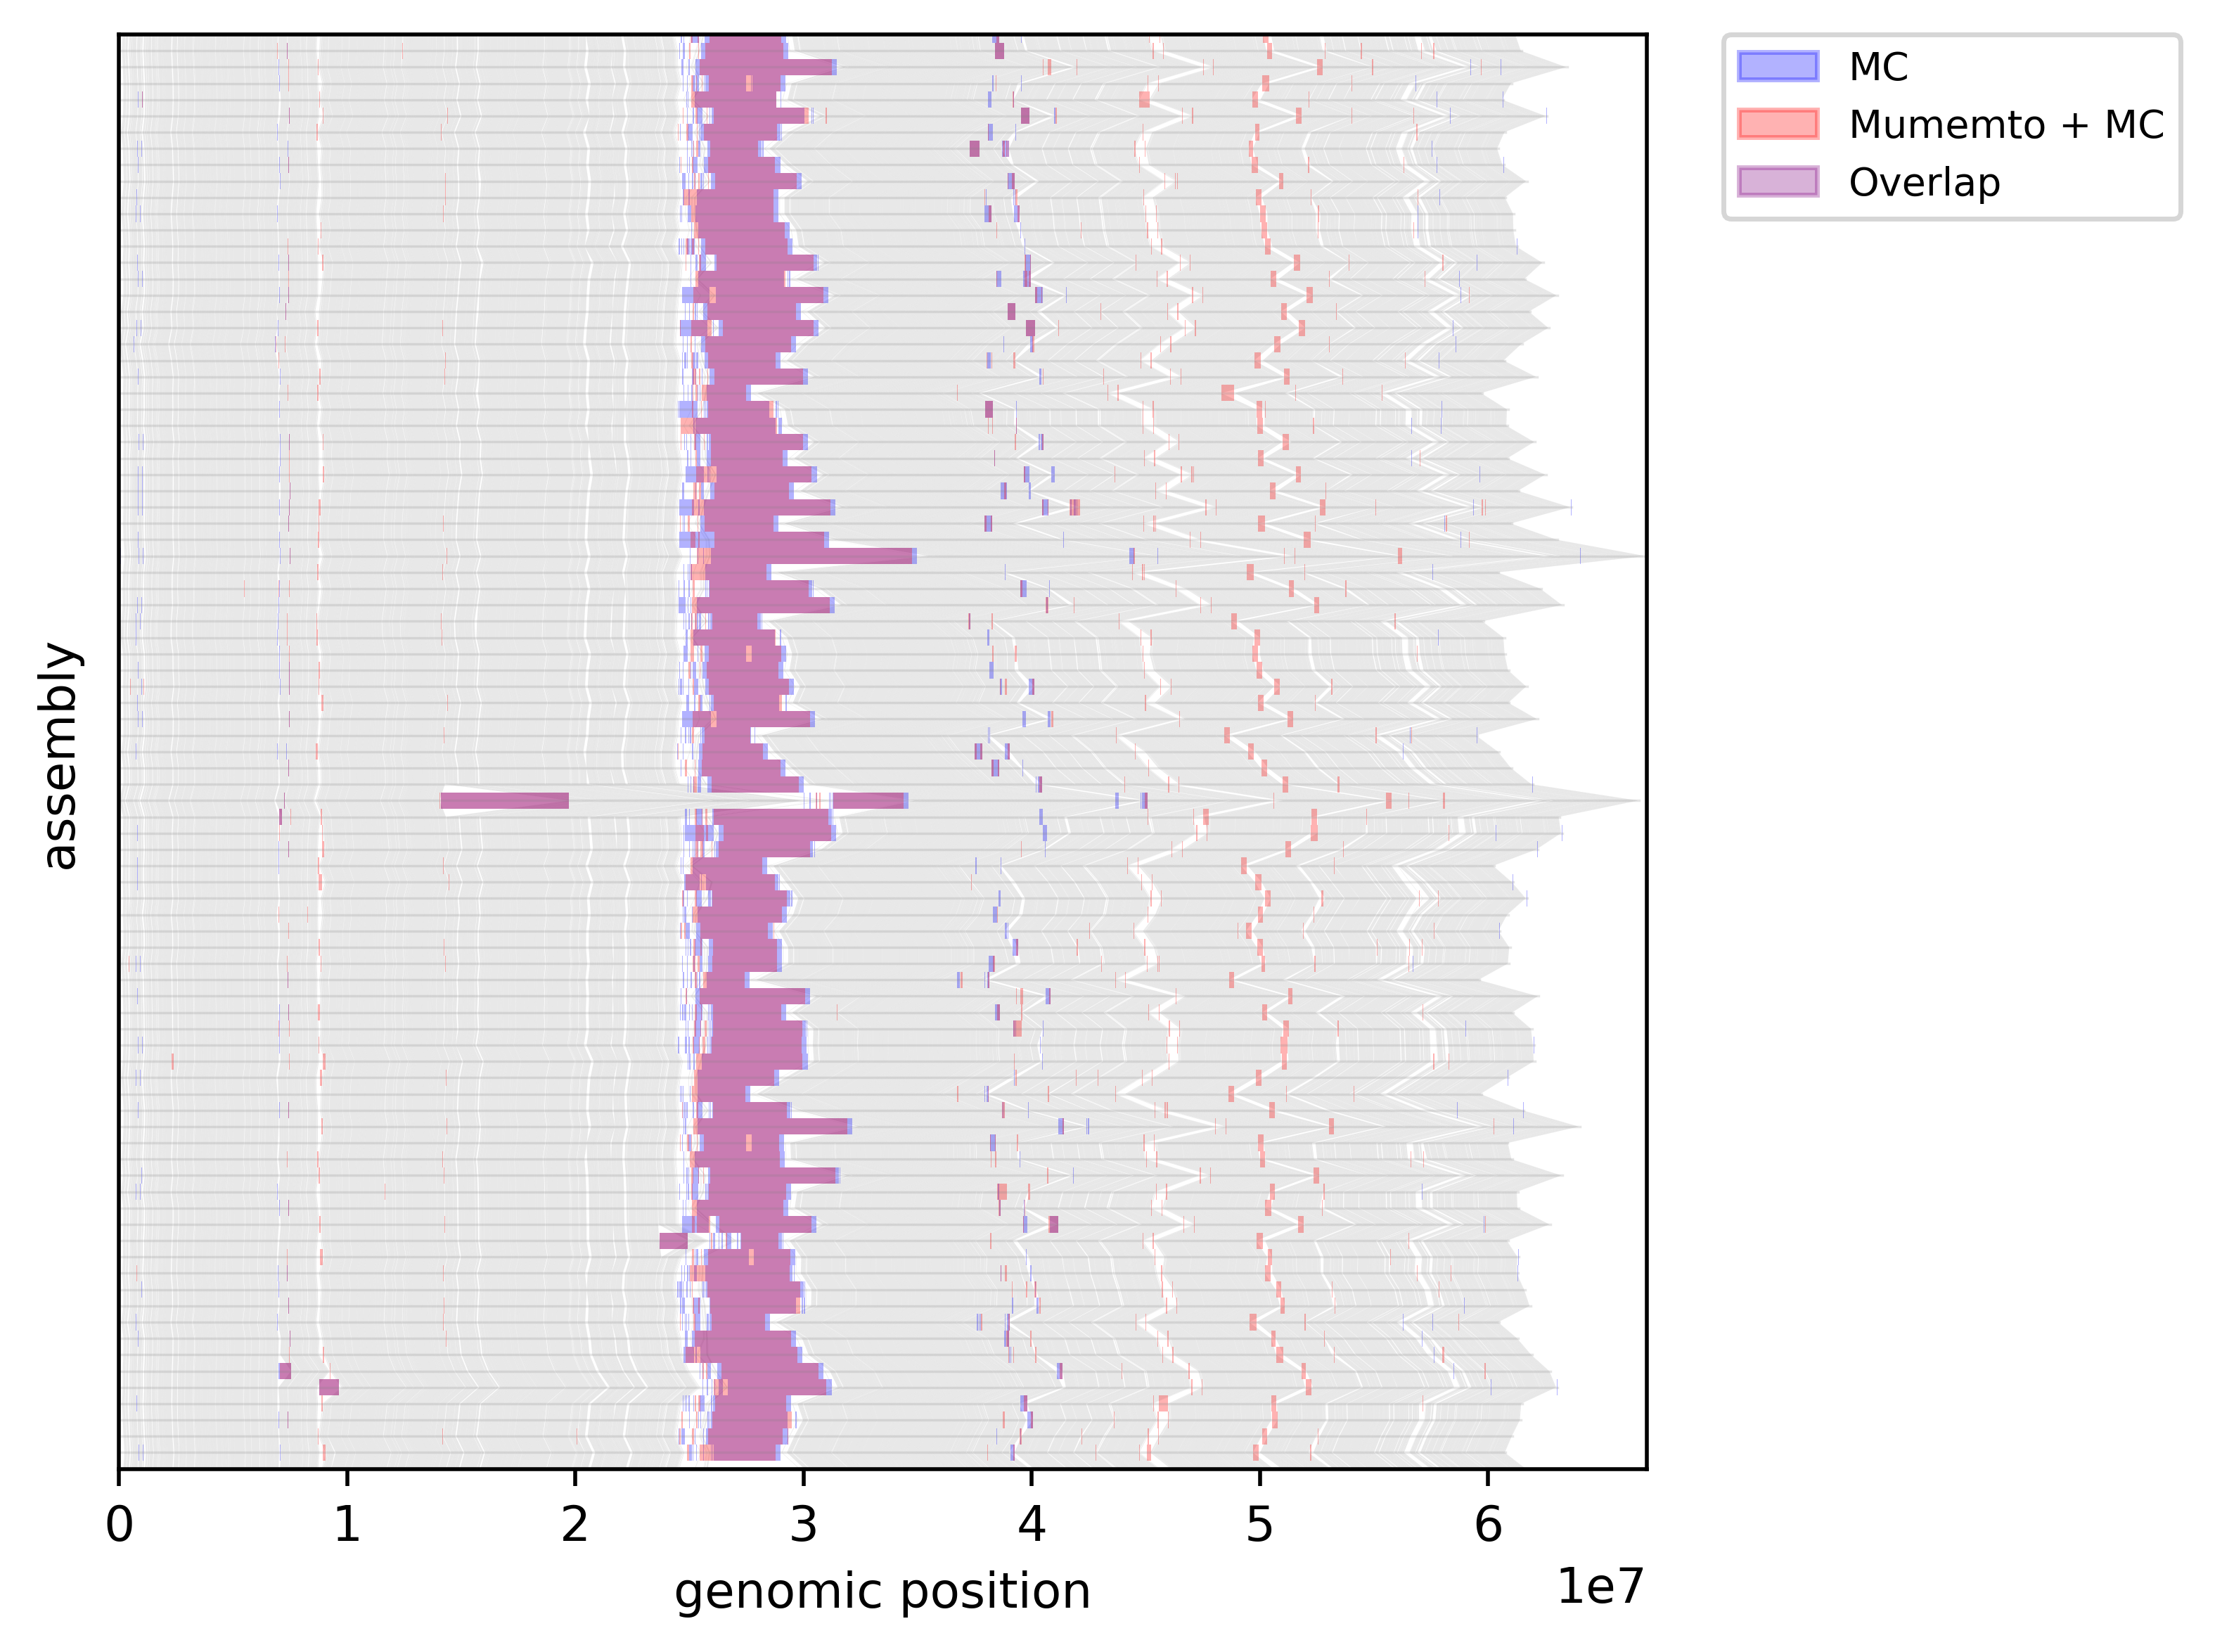

In [30]:
fig, ax_region = draw_synteny_outline_region(seq_lengths, mums, small_blocks, mgc_regions, mum_regions)
ax_region.set_xlabel('genomic position')
ax_region.set_ylabel('assembly')